# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0, os.environ.get('SRC_FIGMA_PATH'))


from cryptocurrencyetl import CryptocurrencyEtl
import context as c
from dataanalysis import DataAnalysis

# 1.0. Data Extraction

In [2]:
crypto = 'BTC'
market_curr = 'USD'
api_key = os.environ.get('TOKEN_FIGMA_CRYPTO_KEY')

crypt_etl = CryptocurrencyEtl(crypto=crypto, market_curr=market_curr, api_key=api_key)

#crypt_etl.test_market_curr()
#crypt_etl.test_crypto()

df_btc_usd = crypt_etl.run()

2022-06-14 22:45:04,589 (INFO)	||| Initing extract of ETL to obtain BTC historical data in USD value!
2022-06-14 22:45:05,978 (INFO)	||| Initing data transform of BTC historical data!
2022-06-14 22:45:05,994 (INFO)	||| ETL finished!


# 2.0. Data Analysis

In [3]:
analy = DataAnalysis(df_btc_usd)

## 2.1. Statistical Description

In [4]:
analy.statistical_description()

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,open,28550.10092,30306.575000,18639.282509,4800.01000,67525.820000,62725.810000,0.240141,-1.415457
1,high,29347.73117,31394.450000,19157.889153,5365.42000,69000.000000,63634.580000,0.227717,-1.434719
2,low,27635.66437,29288.285000,18030.317263,3782.13000,66222.400000,62440.270000,0.254052,-1.394668
3,close,28562.09432,30306.585000,18631.527561,4800.00000,67525.830000,62725.830000,0.239449,-1.414308
4,volume,64917.79045,55435.280824,38289.441405,2389.51482,402201.673764,399812.158944,2.622653,12.422220


## 2.2. Temporal Estability

### 2.2.1. Year

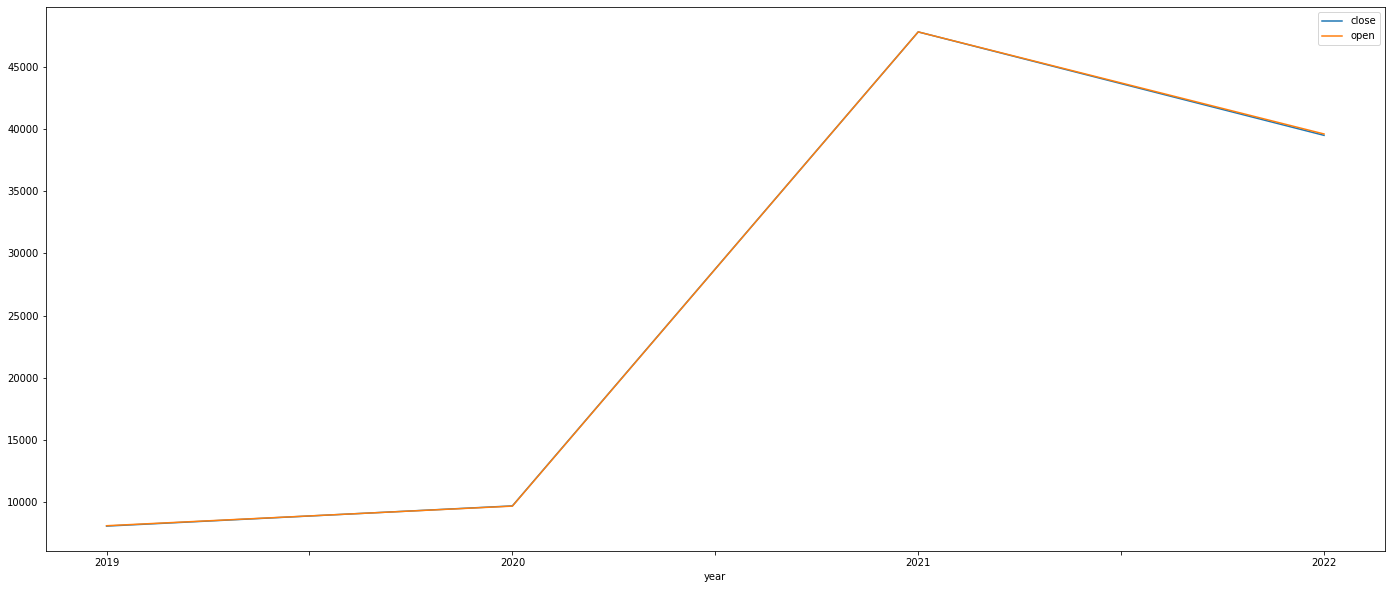

In [5]:
analy.annual_stability(y=['close', 'open'], figsize=(24, 10))

### 2.2.2. Monthly

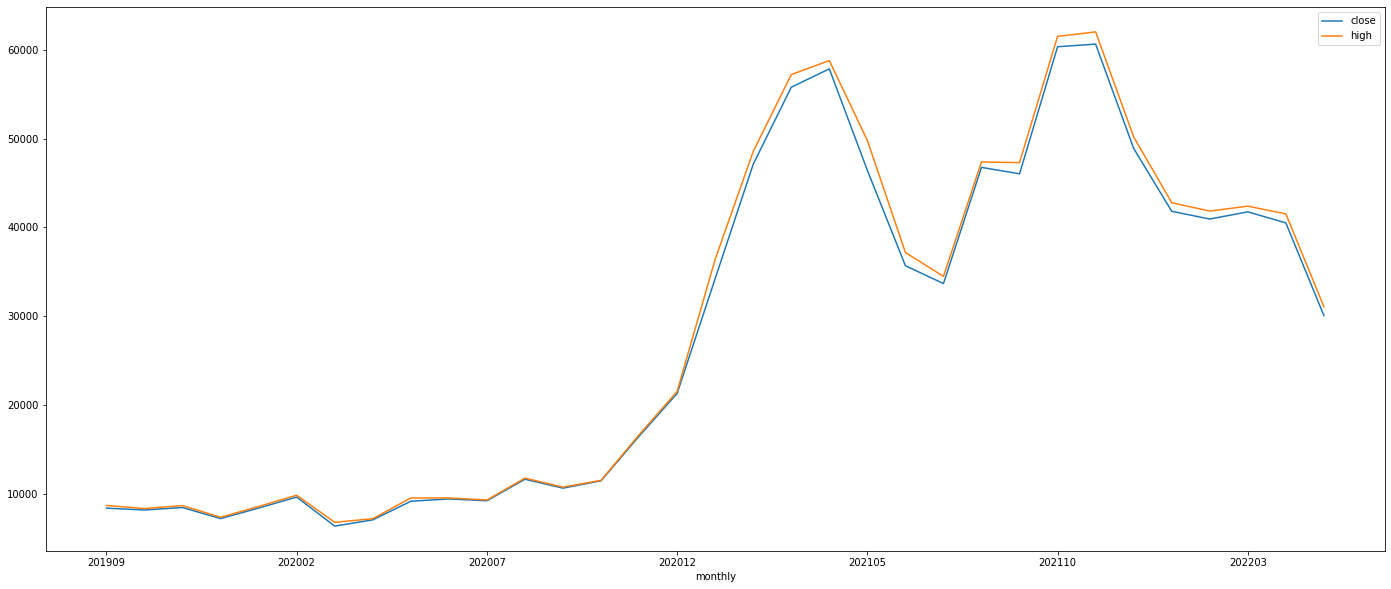

In [6]:
analy.monthly_stability(y=['close', 'high'], figsize=(24, 10))

### 2.2.3. Daily

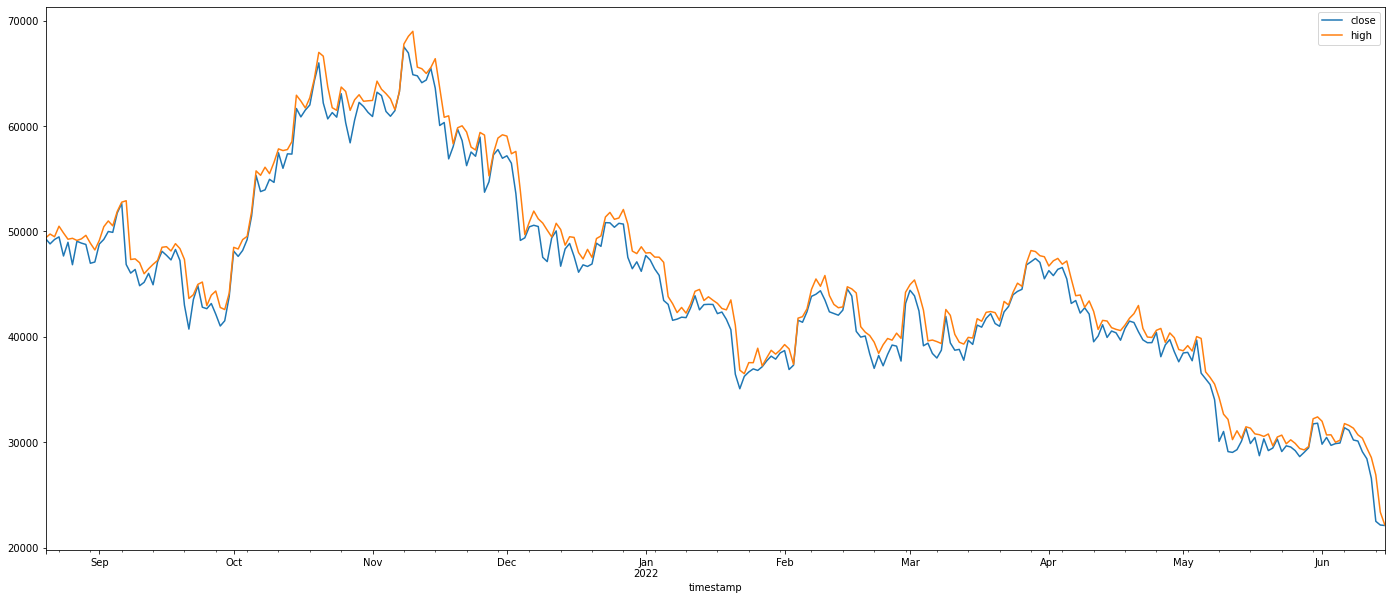

In [7]:
analy.daily_stability(last_days=300, y=['close', 'high'], figsize=(24, 10))

## 2.3. Outlier Identification

### 2.3.1. Year

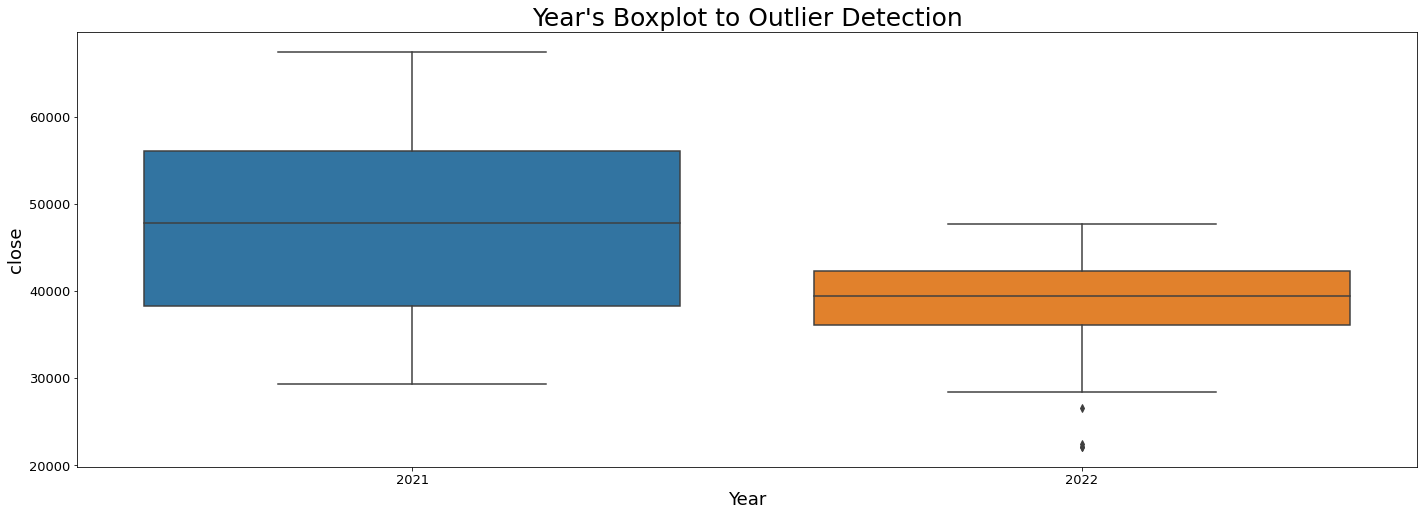

In [8]:
analy.outlier_analysis_boxplot(titlesize=25, x='Year', y='close')

### 2.3.2. Month

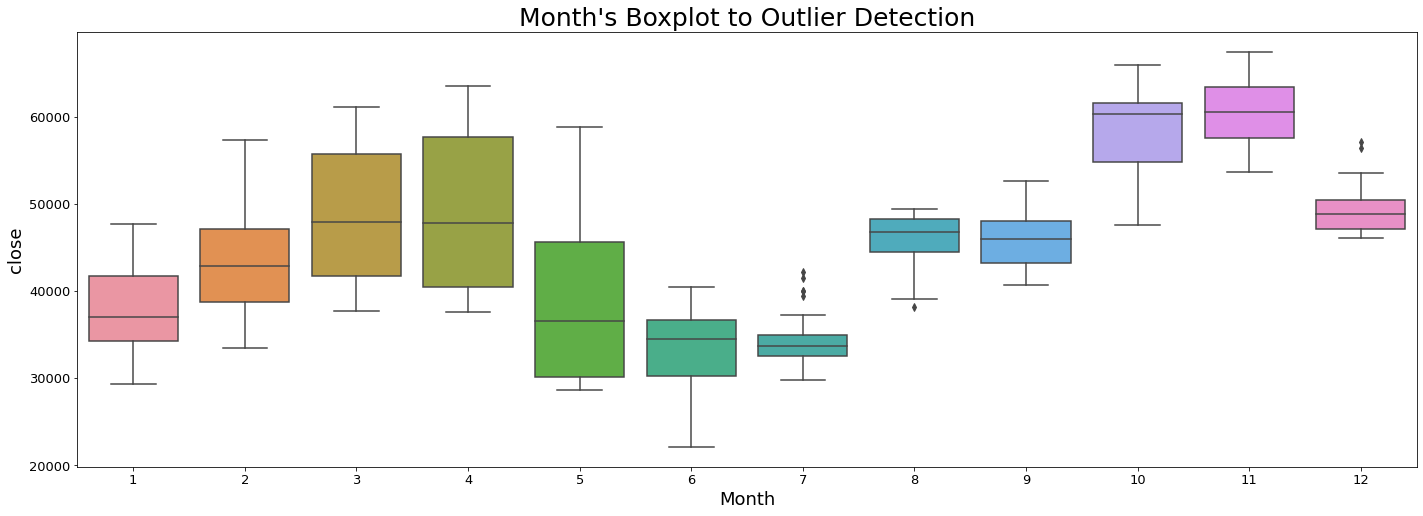

In [9]:
analy.outlier_analysis_boxplot(titlesize=25, x='Month', y='close')

### 2.3.3. Day of Month

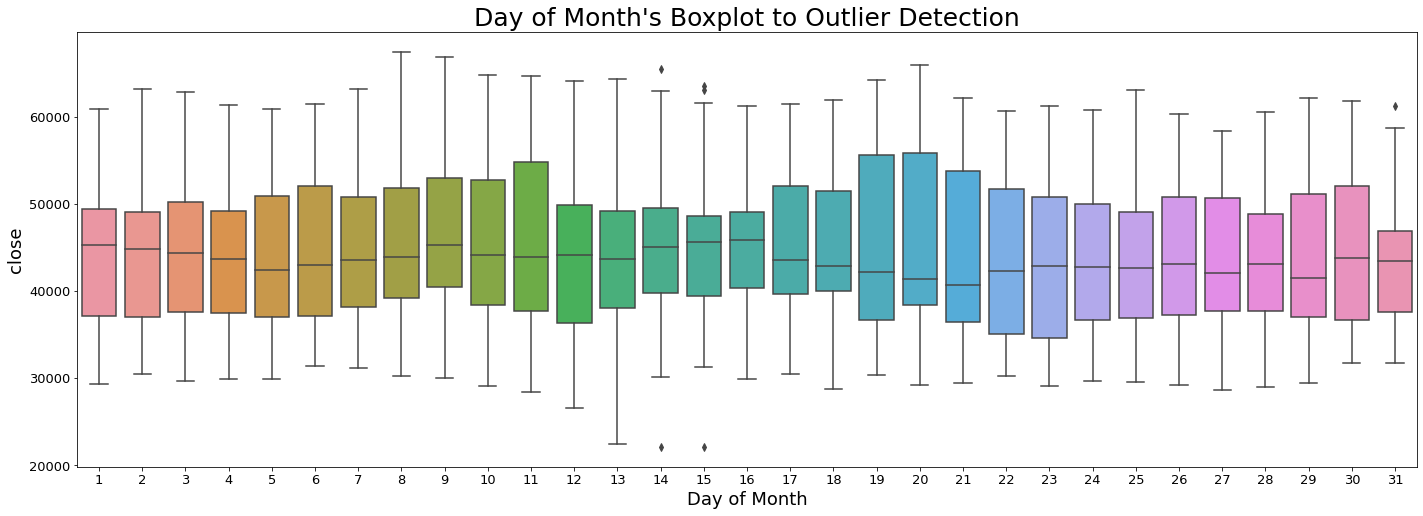

In [10]:
analy.outlier_analysis_boxplot(titlesize=25, x='Day of Month', y='close')

### 2.3.4. Day of Week

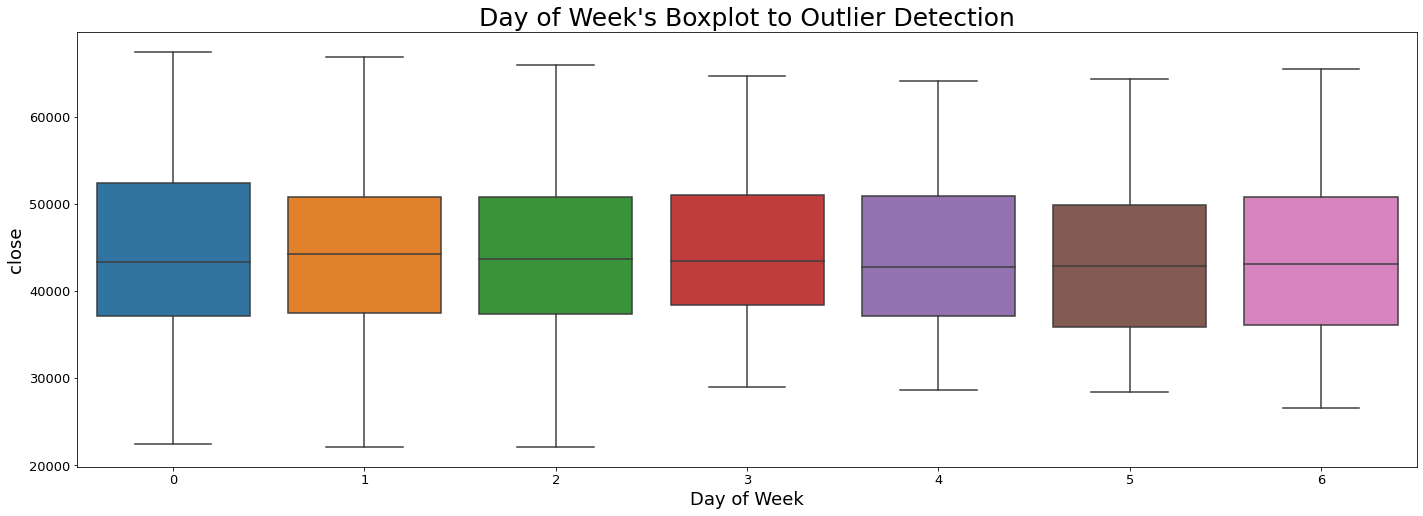

In [11]:
analy.outlier_analysis_boxplot(titlesize=25, x='Day of Week', y='close')

## 2.4. Distribution

## 2.5. Nature Transformation Effect

# 3.0. Data Preparation

## 3.1. Adjust Dataset

## 3.2. Nature Transformation

# 4.0. Machine Learning Model

## 4.1. SARIMAX

### 4.1.1. Modeling

### 4.1.2. Validation

## 4.2. ARIMA

### 4.2.1. Modeling

### 4.2.2. Validation

## 4.3. Saving Model